# Data tidak seimbang dan tanpa fine-tuning

In [ ]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

import tensorflow
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.utils import shuffle 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path_benih = '/content/drive/My Drive/Penelitian/Dataset/'

In [ ]:
kelas = ['haploid', 'diploid']
kelas

['haploid', 'diploid']

In [ ]:
def get_data(data_dir):
    size = (224,224)
    label = 0
    x = []
    y = []
    for folder in kelas:
        print("Loading {}".format(data_dir+folder))
        for pic in tqdm(glob.glob(data_dir + folder + '/*')):
            im = cv2.imread(pic)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            im = cv2.resize(im, (size))
            im = np.array(im)
            x.append(im)
            y.append(label)
        label+=1
    x = np.array(x, dtype = 'float32')
    y = np.array(y, dtype = 'int32')
    return x,y

In [ ]:
x_train, y_train = get_data(path_benih + 'train/')
x_test, y_test = get_data(path_benih + 'test/')

Loading /content/drive/My Drive/Penelitian/Dataset/train/haploid


100%|██████████| 984/984 [00:15<00:00, 65.51it/s] 


Loading /content/drive/My Drive/Penelitian/Dataset/train/diploid


100%|██████████| 1416/1416 [00:23<00:00, 60.19it/s] 


Loading /content/drive/My Drive/Penelitian/Dataset/test/haploid


100%|██████████| 246/246 [00:03<00:00, 77.22it/s] 


Loading /content/drive/My Drive/Penelitian/Dataset/test/diploid


100%|██████████| 354/354 [00:04<00:00, 71.01it/s] 


In [ ]:
x_train/=255.
x_test/=255.

In [ ]:
len(x_train)+len(x_test)

3000

In [ ]:
x_train, y_train = shuffle(x_train, y_train, random_state=42)

In [ ]:
vgg = VGG19(input_shape = (224, 224, 3), include_top=False, weights="imagenet")
vgg.trainable = False
vgg.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
vgg.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
def arsitektur():
  x=Flatten()(vgg.output)
  x=Dense(1024, activation='relu')(x)
  x=Dropout(0.5)(x)
  x=Dense(1024, activation='relu')(x)
  x=Dropout(0.5)(x)
  prediksi=Dense(len(kelas), activation='softmax')(x)
  model=Model(inputs=vgg.input, outputs=prediksi)
  
  return model

In [ ]:
model = arsitektur()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def get_model_name(k):
  return 'model_'+str(k)

In [ ]:
akurasi_val_data=[]
AUC=[]
CV=[]
waktu=[]

LOSS=[]
VAL_LOSS=[]
ACCURACY=[]
VAL_ACCURACY=[]

fold_var = 1
max_epoch = 64
mini_batch = 32
lr = 0.0001

save_dir = '/content/drive/My Drive/Penelitian/save_models/percobaan_1/'

In [ ]:
kf = StratifiedKFold(n_splits=5)
for train_index, val_index in kf.split(x_train, y_train):
  print("---------- FOLD KE- {} ----------".format(fold_var))
  x_training, y_training = x_train[train_index], y_train[train_index]
  x_validasi, y_validasi = x_train[val_index], y_train[val_index]

  y_training = to_categorical(y_training)   
  y_validasi = to_categorical(y_validasi)

  model = arsitektur()
  model.compile(optimizer=Adam(learning_rate=lr), 
                loss='binary_crossentropy',
                metrics=['accuracy'])

  # min_delta (perubahan minimal), patience (jumlah epoch tanpa perbaikan)
  early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=7, verbose=1, mode='auto')
  checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var),
                               monitor='val_accuracy', verbose=1,
                               save_best_only=True, mode='max')
  callback_list = [early_stop, checkpoint]

  start = datetime.datetime.now()
  hist = model.fit(x_training, y_training, 
                   epochs=max_epoch,
                   batch_size=mini_batch,
                   callbacks=callback_list,
                   validation_data = (x_validasi, y_validasi))
  end = datetime.datetime.now()
  jam = end - start

  model = load_model(save_dir+"model_"+str(fold_var))

  predict = model.predict(x_validasi)
  predict = np.argmax(predict, axis=1)
  labels = np.argmax(y_validasi, axis=1)
  print(classification_report(labels, predict, target_names = ['Haploid (Class 0)','Diploid (Class 1)']))
  print('Waktu Pelatihan Data : ', jam, '\n\n')
  acc = accuracy_score(labels, predict)
  auc = roc_auc_score(labels, predict)

  waktu.append(jam)
  akurasi_val_data.append(acc)
  AUC.append(auc)
  LOSS.append(hist.history['loss'])
  ACCURACY.append(hist.history['accuracy'])
  VAL_LOSS.append(hist.history['val_loss'])
  VAL_ACCURACY.append(hist.history['val_accuracy'])
  CV.append('CV-'+str(fold_var))

  clear_session()
  fold_var+=1

---------- FOLD KE- 1 ----------
Epoch 1/64
60/60 [==============================] - ETA: 0s - loss: 0.7482 - accuracy: 0.6057
Epoch 1: val_accuracy improved from -inf to 0.75625, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_1


60/60 [==============================] - 29s 306ms/step - loss: 0.7482 - accuracy: 0.6057 - val_loss: 0.5620 - val_accuracy: 0.7563
Epoch 2/64
60/60 [==============================] - ETA: 0s - loss: 0.5699 - accuracy: 0.7089
Epoch 2: val_accuracy did not improve from 0.75625
60/60 [==============================] - 13s 218ms/step - loss: 0.5699 - accuracy: 0.7089 - val_loss: 0.5433 - val_accuracy: 0.6875
Epoch 3/64
60/60 [==============================] - ETA: 0s - loss: 0.5274 - accuracy: 0.7510
Epoch 3: val_accuracy improved from 0.75625 to 0.78542, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_1


60/60 [==============================] - 17s 292ms/step - loss: 0.5274 - accuracy: 0.7510 - val_loss: 0.4990 - val_accuracy: 0.7854
Epoch 4/64
60/60 [==============================] - ETA: 0s - loss: 0.4732 - accuracy: 0.7844
Epoch 4: val_accuracy improved from 0.78542 to 0.80208, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_1


60/60 [==============================] - 18s 309ms/step - loss: 0.4732 - accuracy: 0.7844 - val_loss: 0.4479 - val_accuracy: 0.8021
Epoch 5/64
60/60 [==============================] - ETA: 0s - loss: 0.4396 - accuracy: 0.8057
Epoch 5: val_accuracy improved from 0.80208 to 0.81250, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_1


60/60 [==============================] - 20s 339ms/step - loss: 0.4396 - accuracy: 0.8057 - val_loss: 0.4255 - val_accuracy: 0.8125
Epoch 6/64
60/60 [==============================] - ETA: 0s - loss: 0.4324 - accuracy: 0.7990
Epoch 6: val_accuracy did not improve from 0.81250
60/60 [==============================] - 13s 223ms/step - loss: 0.4324 - accuracy: 0.7990 - val_loss: 0.4134 - val_accuracy: 0.8125
Epoch 7/64
60/60 [==============================] - ETA: 0s - loss: 0.3927 - accuracy: 0.8219
Epoch 7: val_accuracy did not improve from 0.81250
60/60 [==============================] - 16s 266ms/step - loss: 0.3927 - accuracy: 0.8219 - val_loss: 0.3965 - val_accuracy: 0.8042
Epoch 8/64
60/60 [==============================] - ETA: 0s - loss: 0.3853 - accuracy: 0.8359
Epoch 8: val_accuracy improved from 0.81250 to 0.82500, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_1


60/60 [==============================] - 20s 339ms/step - loss: 0.3853 - accuracy: 0.8359 - val_loss: 0.3781 - val_accuracy: 0.8250
Epoch 9/64
60/60 [==============================] - ETA: 0s - loss: 0.3605 - accuracy: 0.8417
Epoch 9: val_accuracy improved from 0.82500 to 0.82917, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_1


60/60 [==============================] - 20s 338ms/step - loss: 0.3605 - accuracy: 0.8417 - val_loss: 0.3790 - val_accuracy: 0.8292
Epoch 10/64
60/60 [==============================] - ETA: 0s - loss: 0.3315 - accuracy: 0.8599
Epoch 10: val_accuracy did not improve from 0.82917
60/60 [==============================] - 14s 228ms/step - loss: 0.3315 - accuracy: 0.8599 - val_loss: 0.4348 - val_accuracy: 0.7854
Epoch 11/64
60/60 [==============================] - ETA: 0s - loss: 0.3321 - accuracy: 0.8573
Epoch 11: val_accuracy did not improve from 0.82917
60/60 [==============================] - 14s 228ms/step - loss: 0.3321 - accuracy: 0.8573 - val_loss: 0.3749 - val_accuracy: 0.8208
Epoch 12/64
60/60 [==============================] - ETA: 0s - loss: 0.3192 - accuracy: 0.8687
Epoch 12: val_accuracy did not improve from 0.82917
60/60 [==============================] - 14s 230ms/step - loss: 0.3192 - accuracy: 0.8687 - val_loss: 0.3790 - val_accuracy: 0.8104
Epoch 13/64
60/60 [============

60/60 [==============================] - 20s 344ms/step - loss: 0.2887 - accuracy: 0.8823 - val_loss: 0.3437 - val_accuracy: 0.8333
Epoch 15/64
60/60 [==============================] - ETA: 0s - loss: 0.3042 - accuracy: 0.8693
Epoch 15: val_accuracy improved from 0.83333 to 0.83750, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_1


60/60 [==============================] - 20s 339ms/step - loss: 0.3042 - accuracy: 0.8693 - val_loss: 0.3498 - val_accuracy: 0.8375
Epoch 16/64
60/60 [==============================] - ETA: 0s - loss: 0.2761 - accuracy: 0.8823
Epoch 16: val_accuracy did not improve from 0.83750
60/60 [==============================] - 14s 232ms/step - loss: 0.2761 - accuracy: 0.8823 - val_loss: 0.3511 - val_accuracy: 0.8250
Epoch 17/64
60/60 [==============================] - ETA: 0s - loss: 0.2723 - accuracy: 0.8833
Epoch 17: val_accuracy improved from 0.83750 to 0.84792, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_1


60/60 [==============================] - 21s 345ms/step - loss: 0.2723 - accuracy: 0.8833 - val_loss: 0.3465 - val_accuracy: 0.8479
Epoch 18/64
60/60 [==============================] - ETA: 0s - loss: 0.2398 - accuracy: 0.9057
Epoch 18: val_accuracy did not improve from 0.84792
60/60 [==============================] - 16s 270ms/step - loss: 0.2398 - accuracy: 0.9057 - val_loss: 0.3617 - val_accuracy: 0.8479
Epoch 19/64
60/60 [==============================] - ETA: 0s - loss: 0.2637 - accuracy: 0.8948
Epoch 19: val_accuracy did not improve from 0.84792
60/60 [==============================] - 16s 271ms/step - loss: 0.2637 - accuracy: 0.8948 - val_loss: 0.3485 - val_accuracy: 0.8479
Epoch 20/64
60/60 [==============================] - ETA: 0s - loss: 0.2595 - accuracy: 0.8911
Epoch 20: val_accuracy did not improve from 0.84792
60/60 [==============================] - 16s 272ms/step - loss: 0.2595 - accuracy: 0.8911 - val_loss: 0.3446 - val_accuracy: 0.8354
Epoch 21/64
60/60 [============

60/60 [==============================] - 22s 353ms/step - loss: 0.7522 - accuracy: 0.6005 - val_loss: 0.5470 - val_accuracy: 0.7500
Epoch 2/64
60/60 [==============================] - ETA: 0s - loss: 0.5684 - accuracy: 0.7141
Epoch 2: val_accuracy did not improve from 0.75000
60/60 [==============================] - 16s 272ms/step - loss: 0.5684 - accuracy: 0.7141 - val_loss: 0.5151 - val_accuracy: 0.7500
Epoch 3/64
60/60 [==============================] - ETA: 0s - loss: 0.5196 - accuracy: 0.7552
Epoch 3: val_accuracy improved from 0.75000 to 0.81875, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_2


60/60 [==============================] - 21s 351ms/step - loss: 0.5196 - accuracy: 0.7552 - val_loss: 0.4363 - val_accuracy: 0.8188
Epoch 4/64
60/60 [==============================] - ETA: 0s - loss: 0.4722 - accuracy: 0.7870
Epoch 4: val_accuracy did not improve from 0.81875
60/60 [==============================] - 16s 270ms/step - loss: 0.4722 - accuracy: 0.7870 - val_loss: 0.4113 - val_accuracy: 0.8146
Epoch 5/64
60/60 [==============================] - ETA: 0s - loss: 0.4383 - accuracy: 0.8083
Epoch 5: val_accuracy did not improve from 0.81875
60/60 [==============================] - 14s 230ms/step - loss: 0.4383 - accuracy: 0.8083 - val_loss: 0.4655 - val_accuracy: 0.7896
Epoch 6/64
60/60 [==============================] - ETA: 0s - loss: 0.4160 - accuracy: 0.8130
Epoch 6: val_accuracy did not improve from 0.81875
60/60 [==============================] - 16s 271ms/step - loss: 0.4160 - accuracy: 0.8130 - val_loss: 0.3997 - val_accuracy: 0.8083
Epoch 7/64
60/60 [===================

60/60 [==============================] - 21s 346ms/step - loss: 0.3946 - accuracy: 0.8271 - val_loss: 0.3939 - val_accuracy: 0.8313
Epoch 8/64
60/60 [==============================] - ETA: 0s - loss: 0.3818 - accuracy: 0.8224
Epoch 8: val_accuracy did not improve from 0.83125
60/60 [==============================] - 14s 229ms/step - loss: 0.3818 - accuracy: 0.8224 - val_loss: 0.4301 - val_accuracy: 0.8062
Epoch 9/64
60/60 [==============================] - ETA: 0s - loss: 0.3693 - accuracy: 0.8339
Epoch 9: val_accuracy improved from 0.83125 to 0.83958, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_2


60/60 [==============================] - 18s 304ms/step - loss: 0.3693 - accuracy: 0.8339 - val_loss: 0.3472 - val_accuracy: 0.8396
Epoch 10/64
60/60 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.8448
Epoch 10: val_accuracy improved from 0.83958 to 0.85417, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_2


60/60 [==============================] - 21s 346ms/step - loss: 0.3563 - accuracy: 0.8448 - val_loss: 0.3406 - val_accuracy: 0.8542
Epoch 11/64
60/60 [==============================] - ETA: 0s - loss: 0.3351 - accuracy: 0.8516
Epoch 11: val_accuracy did not improve from 0.85417
60/60 [==============================] - 16s 270ms/step - loss: 0.3351 - accuracy: 0.8516 - val_loss: 0.3558 - val_accuracy: 0.8375
Epoch 12/64
60/60 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.8703
Epoch 12: val_accuracy did not improve from 0.85417
60/60 [==============================] - 14s 230ms/step - loss: 0.3067 - accuracy: 0.8703 - val_loss: 0.3461 - val_accuracy: 0.8438
Epoch 13/64
60/60 [==============================] - ETA: 0s - loss: 0.3189 - accuracy: 0.8562
Epoch 13: val_accuracy did not improve from 0.85417
60/60 [==============================] - 16s 273ms/step - loss: 0.3189 - accuracy: 0.8562 - val_loss: 0.3391 - val_accuracy: 0.8458
Epoch 14/64
60/60 [============

60/60 [==============================] - 20s 341ms/step - loss: 0.3069 - accuracy: 0.8698 - val_loss: 0.3363 - val_accuracy: 0.8583
Epoch 16/64
60/60 [==============================] - ETA: 0s - loss: 0.2950 - accuracy: 0.8656
Epoch 16: val_accuracy did not improve from 0.85833
60/60 [==============================] - 16s 270ms/step - loss: 0.2950 - accuracy: 0.8656 - val_loss: 0.3591 - val_accuracy: 0.8313
Epoch 17/64
60/60 [==============================] - ETA: 0s - loss: 0.2907 - accuracy: 0.8823
Epoch 17: val_accuracy did not improve from 0.85833
60/60 [==============================] - 14s 232ms/step - loss: 0.2907 - accuracy: 0.8823 - val_loss: 0.3503 - val_accuracy: 0.8458
Epoch 18/64
60/60 [==============================] - ETA: 0s - loss: 0.2684 - accuracy: 0.8917
Epoch 18: val_accuracy did not improve from 0.85833
60/60 [==============================] - 16s 274ms/step - loss: 0.2684 - accuracy: 0.8917 - val_loss: 0.3692 - val_accuracy: 0.8292
Epoch 19/64
60/60 [============

60/60 [==============================] - 22s 352ms/step - loss: 0.7479 - accuracy: 0.5906 - val_loss: 0.5769 - val_accuracy: 0.6479
Epoch 2/64
60/60 [==============================] - ETA: 0s - loss: 0.5733 - accuracy: 0.7073
Epoch 2: val_accuracy improved from 0.64792 to 0.75208, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_3


60/60 [==============================] - 21s 358ms/step - loss: 0.5733 - accuracy: 0.7073 - val_loss: 0.5084 - val_accuracy: 0.7521
Epoch 3/64
60/60 [==============================] - ETA: 0s - loss: 0.5084 - accuracy: 0.7635
Epoch 3: val_accuracy improved from 0.75208 to 0.76250, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_3


60/60 [==============================] - 18s 307ms/step - loss: 0.5084 - accuracy: 0.7635 - val_loss: 0.4816 - val_accuracy: 0.7625
Epoch 4/64
60/60 [==============================] - ETA: 0s - loss: 0.4604 - accuracy: 0.7948
Epoch 4: val_accuracy did not improve from 0.76250
60/60 [==============================] - 14s 232ms/step - loss: 0.4604 - accuracy: 0.7948 - val_loss: 0.5012 - val_accuracy: 0.7354
Epoch 5/64
60/60 [==============================] - ETA: 0s - loss: 0.4316 - accuracy: 0.8078
Epoch 5: val_accuracy improved from 0.76250 to 0.78542, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_3


60/60 [==============================] - 18s 306ms/step - loss: 0.4316 - accuracy: 0.8078 - val_loss: 0.4562 - val_accuracy: 0.7854
Epoch 6/64
60/60 [==============================] - ETA: 0s - loss: 0.4131 - accuracy: 0.8078
Epoch 6: val_accuracy improved from 0.78542 to 0.79375, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_3


60/60 [==============================] - 19s 313ms/step - loss: 0.4131 - accuracy: 0.8078 - val_loss: 0.4508 - val_accuracy: 0.7937
Epoch 7/64
60/60 [==============================] - ETA: 0s - loss: 0.3915 - accuracy: 0.8255
Epoch 7: val_accuracy did not improve from 0.79375
60/60 [==============================] - 14s 239ms/step - loss: 0.3915 - accuracy: 0.8255 - val_loss: 0.4474 - val_accuracy: 0.7917
Epoch 8/64
60/60 [==============================] - ETA: 0s - loss: 0.3537 - accuracy: 0.8458
Epoch 8: val_accuracy did not improve from 0.79375
60/60 [==============================] - 16s 274ms/step - loss: 0.3537 - accuracy: 0.8458 - val_loss: 0.4622 - val_accuracy: 0.7771
Epoch 9/64
60/60 [==============================] - ETA: 0s - loss: 0.3401 - accuracy: 0.8562
Epoch 9: val_accuracy improved from 0.79375 to 0.82083, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_3


60/60 [==============================] - 21s 346ms/step - loss: 0.3401 - accuracy: 0.8562 - val_loss: 0.4251 - val_accuracy: 0.8208
Epoch 10/64
60/60 [==============================] - ETA: 0s - loss: 0.3380 - accuracy: 0.8521
Epoch 10: val_accuracy did not improve from 0.82083
60/60 [==============================] - 16s 271ms/step - loss: 0.3380 - accuracy: 0.8521 - val_loss: 0.4420 - val_accuracy: 0.7896
Epoch 11/64
60/60 [==============================] - ETA: 0s - loss: 0.3185 - accuracy: 0.8604
Epoch 11: val_accuracy did not improve from 0.82083
60/60 [==============================] - 16s 271ms/step - loss: 0.3185 - accuracy: 0.8604 - val_loss: 0.4124 - val_accuracy: 0.8000
Epoch 12/64
60/60 [==============================] - ETA: 0s - loss: 0.3042 - accuracy: 0.8734
Epoch 12: val_accuracy did not improve from 0.82083
60/60 [==============================] - 16s 273ms/step - loss: 0.3042 - accuracy: 0.8734 - val_loss: 0.4536 - val_accuracy: 0.8021
Epoch 13/64
60/60 [============

60/60 [==============================] - 20s 342ms/step - loss: 0.2630 - accuracy: 0.8927 - val_loss: 0.4131 - val_accuracy: 0.8354
Epoch 19/64
60/60 [==============================] - ETA: 0s - loss: 0.2362 - accuracy: 0.9047
Epoch 19: val_accuracy did not improve from 0.83542
60/60 [==============================] - 16s 270ms/step - loss: 0.2362 - accuracy: 0.9047 - val_loss: 0.4054 - val_accuracy: 0.8125
Epoch 20/64
60/60 [==============================] - ETA: 0s - loss: 0.2385 - accuracy: 0.9052
Epoch 20: val_accuracy did not improve from 0.83542
60/60 [==============================] - 14s 232ms/step - loss: 0.2385 - accuracy: 0.9052 - val_loss: 0.4592 - val_accuracy: 0.7875
Epoch 21/64
60/60 [==============================] - ETA: 0s - loss: 0.2112 - accuracy: 0.9151
Epoch 21: val_accuracy did not improve from 0.83542
60/60 [==============================] - 14s 232ms/step - loss: 0.2112 - accuracy: 0.9151 - val_loss: 0.4171 - val_accuracy: 0.8125
Epoch 22/64
60/60 [============

60/60 [==============================] - 22s 354ms/step - loss: 0.7396 - accuracy: 0.6344 - val_loss: 0.5320 - val_accuracy: 0.7458
Epoch 2/64
60/60 [==============================] - ETA: 0s - loss: 0.5658 - accuracy: 0.7203
Epoch 2: val_accuracy did not improve from 0.74583
60/60 [==============================] - 14s 232ms/step - loss: 0.5658 - accuracy: 0.7203 - val_loss: 0.4889 - val_accuracy: 0.7458
Epoch 3/64
60/60 [==============================] - ETA: 0s - loss: 0.5004 - accuracy: 0.7568
Epoch 3: val_accuracy improved from 0.74583 to 0.80000, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_4


60/60 [==============================] - 19s 322ms/step - loss: 0.5004 - accuracy: 0.7568 - val_loss: 0.4368 - val_accuracy: 0.8000
Epoch 4/64
60/60 [==============================] - ETA: 0s - loss: 0.4542 - accuracy: 0.7948
Epoch 4: val_accuracy did not improve from 0.80000
60/60 [==============================] - 14s 230ms/step - loss: 0.4542 - accuracy: 0.7948 - val_loss: 0.4161 - val_accuracy: 0.7979
Epoch 5/64
60/60 [==============================] - ETA: 0s - loss: 0.4266 - accuracy: 0.8078
Epoch 5: val_accuracy improved from 0.80000 to 0.80208, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_4


60/60 [==============================] - 20s 343ms/step - loss: 0.4266 - accuracy: 0.8078 - val_loss: 0.4445 - val_accuracy: 0.8021
Epoch 6/64
60/60 [==============================] - ETA: 0s - loss: 0.4270 - accuracy: 0.8021
Epoch 6: val_accuracy improved from 0.80208 to 0.82083, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_4


60/60 [==============================] - 19s 318ms/step - loss: 0.4270 - accuracy: 0.8021 - val_loss: 0.3950 - val_accuracy: 0.8208
Epoch 7/64
60/60 [==============================] - ETA: 0s - loss: 0.3897 - accuracy: 0.8203
Epoch 7: val_accuracy did not improve from 0.82083
60/60 [==============================] - 14s 234ms/step - loss: 0.3897 - accuracy: 0.8203 - val_loss: 0.3937 - val_accuracy: 0.8188
Epoch 8/64
60/60 [==============================] - ETA: 0s - loss: 0.3858 - accuracy: 0.8385
Epoch 8: val_accuracy improved from 0.82083 to 0.84167, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_4


60/60 [==============================] - 21s 346ms/step - loss: 0.3858 - accuracy: 0.8385 - val_loss: 0.3613 - val_accuracy: 0.8417
Epoch 9/64
60/60 [==============================] - ETA: 0s - loss: 0.3467 - accuracy: 0.8453
Epoch 9: val_accuracy improved from 0.84167 to 0.84375, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_4


60/60 [==============================] - 19s 312ms/step - loss: 0.3467 - accuracy: 0.8453 - val_loss: 0.3667 - val_accuracy: 0.8438
Epoch 10/64
60/60 [==============================] - ETA: 0s - loss: 0.3438 - accuracy: 0.8547
Epoch 10: val_accuracy did not improve from 0.84375
60/60 [==============================] - 16s 271ms/step - loss: 0.3438 - accuracy: 0.8547 - val_loss: 0.3414 - val_accuracy: 0.8417
Epoch 11/64
60/60 [==============================] - ETA: 0s - loss: 0.3253 - accuracy: 0.8630
Epoch 11: val_accuracy improved from 0.84375 to 0.85208, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_4


60/60 [==============================] - 20s 342ms/step - loss: 0.3253 - accuracy: 0.8630 - val_loss: 0.3402 - val_accuracy: 0.8521
Epoch 12/64
60/60 [==============================] - ETA: 0s - loss: 0.3157 - accuracy: 0.8635
Epoch 12: val_accuracy did not improve from 0.85208
60/60 [==============================] - 14s 229ms/step - loss: 0.3157 - accuracy: 0.8635 - val_loss: 0.3481 - val_accuracy: 0.8521
Epoch 13/64
60/60 [==============================] - ETA: 0s - loss: 0.3214 - accuracy: 0.8661
Epoch 13: val_accuracy improved from 0.85208 to 0.85625, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_4


60/60 [==============================] - 20s 341ms/step - loss: 0.3214 - accuracy: 0.8661 - val_loss: 0.3349 - val_accuracy: 0.8562
Epoch 14/64
60/60 [==============================] - ETA: 0s - loss: 0.2937 - accuracy: 0.8760
Epoch 14: val_accuracy did not improve from 0.85625
60/60 [==============================] - 14s 229ms/step - loss: 0.2937 - accuracy: 0.8760 - val_loss: 0.3895 - val_accuracy: 0.8375
Epoch 15/64
60/60 [==============================] - ETA: 0s - loss: 0.3078 - accuracy: 0.8672
Epoch 15: val_accuracy did not improve from 0.85625
60/60 [==============================] - 14s 232ms/step - loss: 0.3078 - accuracy: 0.8672 - val_loss: 0.3733 - val_accuracy: 0.8417
Epoch 16/64
60/60 [==============================] - ETA: 0s - loss: 0.2951 - accuracy: 0.8729
Epoch 16: val_accuracy did not improve from 0.85625
60/60 [==============================] - 16s 272ms/step - loss: 0.2951 - accuracy: 0.8729 - val_loss: 0.3732 - val_accuracy: 0.8104
Epoch 17/64
60/60 [============

60/60 [==============================] - 21s 344ms/step - loss: 0.2673 - accuracy: 0.8875 - val_loss: 0.3317 - val_accuracy: 0.8646
Epoch 19/64
60/60 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.8958
Epoch 19: val_accuracy did not improve from 0.86458
60/60 [==============================] - 14s 230ms/step - loss: 0.2686 - accuracy: 0.8958 - val_loss: 0.3426 - val_accuracy: 0.8438
Epoch 20/64
60/60 [==============================] - ETA: 0s - loss: 0.2616 - accuracy: 0.8896
Epoch 20: val_accuracy improved from 0.86458 to 0.87917, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_4


60/60 [==============================] - 21s 350ms/step - loss: 0.2616 - accuracy: 0.8896 - val_loss: 0.3363 - val_accuracy: 0.8792
Epoch 21/64
60/60 [==============================] - ETA: 0s - loss: 0.2501 - accuracy: 0.8854
Epoch 21: val_accuracy did not improve from 0.87917
60/60 [==============================] - 14s 229ms/step - loss: 0.2501 - accuracy: 0.8854 - val_loss: 0.3366 - val_accuracy: 0.8583
Epoch 22/64
60/60 [==============================] - ETA: 0s - loss: 0.2389 - accuracy: 0.9052
Epoch 22: val_accuracy did not improve from 0.87917
60/60 [==============================] - 16s 272ms/step - loss: 0.2389 - accuracy: 0.9052 - val_loss: 0.3367 - val_accuracy: 0.8687
Epoch 23/64
60/60 [==============================] - ETA: 0s - loss: 0.2174 - accuracy: 0.9125
Epoch 23: val_accuracy did not improve from 0.87917
60/60 [==============================] - 16s 273ms/step - loss: 0.2174 - accuracy: 0.9125 - val_loss: 0.3645 - val_accuracy: 0.8354
Epoch 24/64
60/60 [============

60/60 [==============================] - 21s 347ms/step - loss: 0.7226 - accuracy: 0.6016 - val_loss: 0.5812 - val_accuracy: 0.6271
Epoch 2/64
60/60 [==============================] - ETA: 0s - loss: 0.5623 - accuracy: 0.7271
Epoch 2: val_accuracy improved from 0.62708 to 0.78333, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_5


60/60 [==============================] - 19s 317ms/step - loss: 0.5623 - accuracy: 0.7271 - val_loss: 0.4817 - val_accuracy: 0.7833
Epoch 3/64
60/60 [==============================] - ETA: 0s - loss: 0.5051 - accuracy: 0.7552
Epoch 3: val_accuracy improved from 0.78333 to 0.79167, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_5


60/60 [==============================] - 21s 347ms/step - loss: 0.5051 - accuracy: 0.7552 - val_loss: 0.4474 - val_accuracy: 0.7917
Epoch 4/64
60/60 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.7786
Epoch 4: val_accuracy improved from 0.79167 to 0.80208, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_5


60/60 [==============================] - 20s 343ms/step - loss: 0.4764 - accuracy: 0.7786 - val_loss: 0.4405 - val_accuracy: 0.8021
Epoch 5/64
60/60 [==============================] - ETA: 0s - loss: 0.4428 - accuracy: 0.7958
Epoch 5: val_accuracy improved from 0.80208 to 0.81042, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_5


60/60 [==============================] - 21s 347ms/step - loss: 0.4428 - accuracy: 0.7958 - val_loss: 0.4132 - val_accuracy: 0.8104
Epoch 6/64
60/60 [==============================] - ETA: 0s - loss: 0.4153 - accuracy: 0.8167
Epoch 6: val_accuracy did not improve from 0.81042
60/60 [==============================] - 14s 232ms/step - loss: 0.4153 - accuracy: 0.8167 - val_loss: 0.4047 - val_accuracy: 0.8062
Epoch 7/64
60/60 [==============================] - ETA: 0s - loss: 0.4017 - accuracy: 0.8167
Epoch 7: val_accuracy did not improve from 0.81042
60/60 [==============================] - 14s 234ms/step - loss: 0.4017 - accuracy: 0.8167 - val_loss: 0.4718 - val_accuracy: 0.7750
Epoch 8/64
60/60 [==============================] - ETA: 0s - loss: 0.3781 - accuracy: 0.8359
Epoch 8: val_accuracy improved from 0.81042 to 0.83125, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_5


60/60 [==============================] - 18s 302ms/step - loss: 0.3781 - accuracy: 0.8359 - val_loss: 0.3696 - val_accuracy: 0.8313
Epoch 9/64
60/60 [==============================] - ETA: 0s - loss: 0.3439 - accuracy: 0.8557
Epoch 9: val_accuracy did not improve from 0.83125
60/60 [==============================] - 16s 270ms/step - loss: 0.3439 - accuracy: 0.8557 - val_loss: 0.4033 - val_accuracy: 0.8229
Epoch 10/64
60/60 [==============================] - ETA: 0s - loss: 0.3536 - accuracy: 0.8448
Epoch 10: val_accuracy improved from 0.83125 to 0.83750, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_5


60/60 [==============================] - 18s 301ms/step - loss: 0.3536 - accuracy: 0.8448 - val_loss: 0.3648 - val_accuracy: 0.8375
Epoch 11/64
60/60 [==============================] - ETA: 0s - loss: 0.3194 - accuracy: 0.8693
Epoch 11: val_accuracy did not improve from 0.83750
60/60 [==============================] - 16s 273ms/step - loss: 0.3194 - accuracy: 0.8693 - val_loss: 0.3558 - val_accuracy: 0.8354
Epoch 12/64
60/60 [==============================] - ETA: 0s - loss: 0.3236 - accuracy: 0.8521
Epoch 12: val_accuracy did not improve from 0.83750
60/60 [==============================] - 14s 232ms/step - loss: 0.3236 - accuracy: 0.8521 - val_loss: 0.3969 - val_accuracy: 0.8146
Epoch 13/64
60/60 [==============================] - ETA: 0s - loss: 0.3241 - accuracy: 0.8552
Epoch 13: val_accuracy did not improve from 0.83750
60/60 [==============================] - 16s 273ms/step - loss: 0.3241 - accuracy: 0.8552 - val_loss: 0.3591 - val_accuracy: 0.8354
Epoch 14/64
60/60 [============

60/60 [==============================] - 21s 350ms/step - loss: 0.2881 - accuracy: 0.8802 - val_loss: 0.3579 - val_accuracy: 0.8417
Epoch 15/64
60/60 [==============================] - ETA: 0s - loss: 0.2812 - accuracy: 0.8823
Epoch 15: val_accuracy improved from 0.84167 to 0.84792, saving model to /content/drive/My Drive/Penelitian/save/ujicoba_11/model_5


60/60 [==============================] - 20s 343ms/step - loss: 0.2812 - accuracy: 0.8823 - val_loss: 0.3506 - val_accuracy: 0.8479
Epoch 16/64
60/60 [==============================] - ETA: 0s - loss: 0.2876 - accuracy: 0.8786
Epoch 16: val_accuracy did not improve from 0.84792
60/60 [==============================] - 16s 272ms/step - loss: 0.2876 - accuracy: 0.8786 - val_loss: 0.3543 - val_accuracy: 0.8458
Epoch 17/64
60/60 [==============================] - ETA: 0s - loss: 0.2515 - accuracy: 0.9052
Epoch 17: val_accuracy did not improve from 0.84792
60/60 [==============================] - 16s 275ms/step - loss: 0.2515 - accuracy: 0.9052 - val_loss: 0.3717 - val_accuracy: 0.8375
Epoch 18/64
60/60 [==============================] - ETA: 0s - loss: 0.2644 - accuracy: 0.8896
Epoch 18: val_accuracy did not improve from 0.84792
60/60 [==============================] - 16s 272ms/step - loss: 0.2644 - accuracy: 0.8896 - val_loss: 0.3411 - val_accuracy: 0.8396
Epoch 19/64
60/60 [============

60/60 [==============================] - 21s 344ms/step - loss: 0.2384 - accuracy: 0.9073 - val_loss: 0.3385 - val_accuracy: 0.8562
Epoch 24/64
60/60 [==============================] - ETA: 0s - loss: 0.2179 - accuracy: 0.9099
Epoch 24: val_accuracy did not improve from 0.85625
60/60 [==============================] - 16s 271ms/step - loss: 0.2179 - accuracy: 0.9099 - val_loss: 0.3548 - val_accuracy: 0.8417
Epoch 25/64
60/60 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.9182
Epoch 25: val_accuracy did not improve from 0.85625
60/60 [==============================] - 14s 232ms/step - loss: 0.2120 - accuracy: 0.9182 - val_loss: 0.3615 - val_accuracy: 0.8521
Epoch 26/64
60/60 [==============================] - ETA: 0s - loss: 0.2101 - accuracy: 0.9193
Epoch 26: val_accuracy did not improve from 0.85625
60/60 [==============================] - 16s 272ms/step - loss: 0.2101 - accuracy: 0.9193 - val_loss: 0.3518 - val_accuracy: 0.8438
Epoch 27/64
60/60 [============

In [ ]:
print(akurasi_val_data)
print(AUC)
print(CV)
print(waktu)

print(LOSS)
print(VAL_LOSS)
print(ACCURACY)
print(VAL_ACCURACY)

[0.8479166666666667, 0.8583333333333333, 0.8354166666666667, 0.8791666666666667, 0.85625]
[0.8461842483472263, 0.8536349123782534, 0.8365141432440675, 0.8797869096518448, 0.8518681279259566]
['CV-1', 'CV-2', 'CV-3', 'CV-4', 'CV-5']
[datetime.timedelta(seconds=363, microseconds=811817), datetime.timedelta(seconds=370, microseconds=554714), datetime.timedelta(seconds=513, microseconds=639116), datetime.timedelta(seconds=427, microseconds=233859), datetime.timedelta(seconds=514, microseconds=469776)]
[[0.7481517791748047, 0.5698611736297607, 0.5274441242218018, 0.4731591045856476, 0.439555823802948, 0.4323670268058777, 0.39269235730171204, 0.38527533411979675, 0.36045315861701965, 0.3314579129219055, 0.33212366700172424, 0.3192480206489563, 0.3116862177848816, 0.28869014978408813, 0.30417147278785706, 0.2761162519454956, 0.2723254859447479, 0.23975247144699097, 0.2636520266532898, 0.25952595472335815, 0.2456028312444687], [0.7522106170654297, 0.568412721157074, 0.5196103453636169, 0.47217

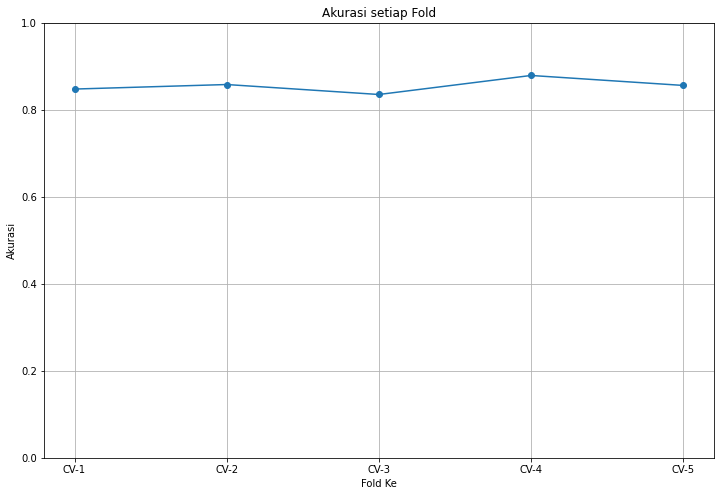

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(CV, akurasi_val_data, marker='o')
plt.title('Akurasi setiap Fold')
plt.xlabel('Fold Ke')
plt.ylabel('Akurasi')
plt.ylim((0., 1))
plt.grid()
plt.show()

In [ ]:
def visualisasi_fit(judul, n_train, n_val):
  fig, ax = plt.subplots(3,2,constrained_layout=True, figsize=(15,10))
  index=0
  for i in range(3):
    for j in range(2):
      if j==0:
        ax[i,j].set_title('CV' + str(index+1) + judul)
        ax[i,j].plot(n_train[index], '--', label=judul)
        ax[i,j].plot(n_val[index], label='Val_'+judul)
        ax[i,j].set_xlabel('x-axis')
        ax[i,j].set_ylabel('y-axis')
      else:
        if index==5:
          break
        ax[i,j].set_title('CV' + str(index+1) + judul)
        ax[i,j].set_xlabel('x-axis')
        ax[i,j].set_ylabel('y-axis')
        ax[i,j].plot(n_train[index], '--', label=judul)
        ax[i,j].plot(n_val[index], label='Val_'+judul)
      ax[i,j].grid()
      ax[i,j].set_ylim((0., 1))
      ax[i,j].legend()
      index+=1

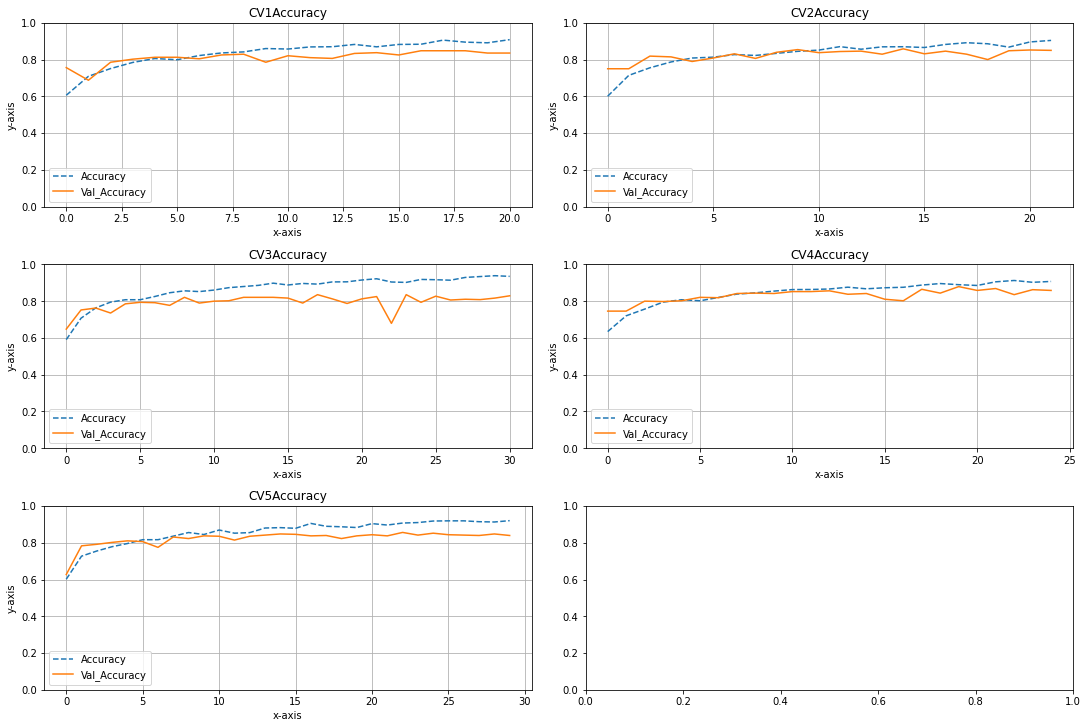

In [ ]:
vis_akurasi = visualisasi_fit('Accuracy', ACCURACY, VAL_ACCURACY)
vis_akurasi

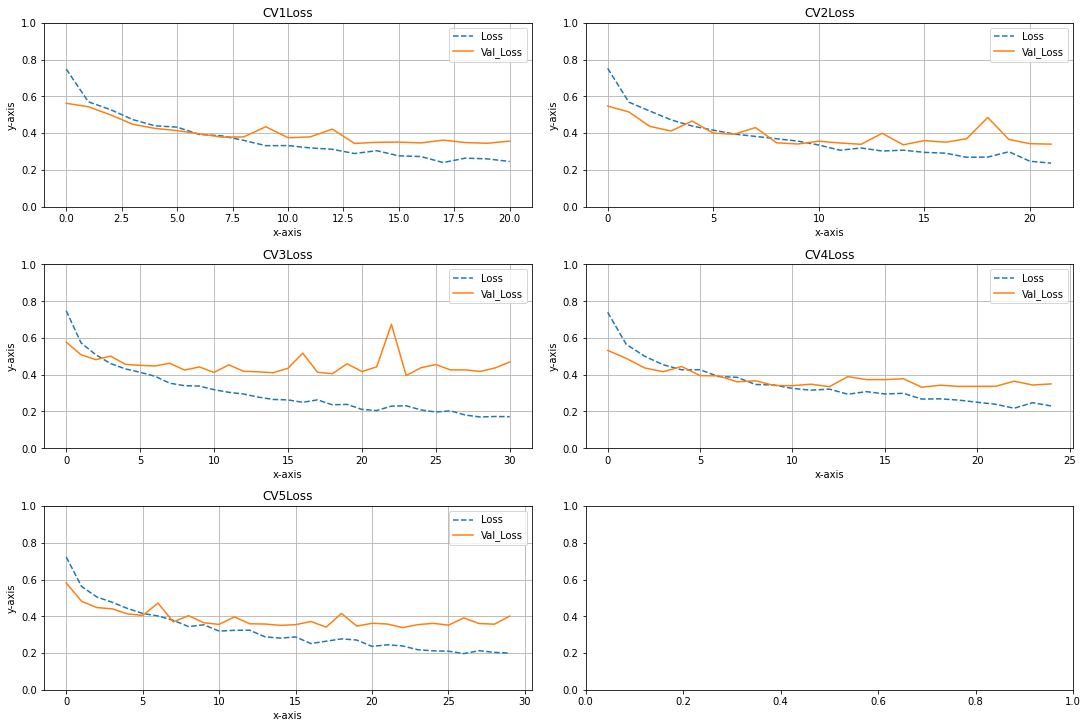

In [ ]:
vis_loss = visualisasi_fit('Loss', LOSS, VAL_LOSS)
vis_loss

In [ ]:
terbaik=[]
for i in range(5):
  nilai = (akurasi_val_data[i]+AUC[i])/2
  terbaik.append(nilai)

In [ ]:
terbaik

[0.8470504575069464,
 0.8559841228557934,
 0.8359654049553671,
 0.8794767881592558,
 0.8540590639629783]

In [ ]:
s=0
baik=1
for i, v in enumerate(terbaik):
  if v>s:
    s=v
    baik=i+1
  else:
    continue
print(baik, s)

4 0.8794767881592558


In [ ]:
model = load_model(save_dir+"model_"str(baik))
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

19/19 [==============================] - 6s 295ms/step


In [ ]:
acc_test = accuracy_score(y_test, y_pred)
prec_test = precision_score(y_test, y_pred)
rec_test = recall_score(y_test, y_pred)
f1score_test = f1_score(y_test, y_pred)

In [ ]:
print('Acc Test : ', acc_test)
print('Prec Test : ', prec_test)
print('Rec Test : ', rec_test)
print('F1-Score Test : ', f1score_test)

Acc Test :  0.9183333333333333
Prec Test :  0.8961038961038961
Rec Test :  0.9745762711864406
F1-Score Test :  0.9336941813261163


In [ ]:
print(classification_report(y_test, y_pred, target_names = ['Haploid (Class 0)','Diploid (Class 1)']))

                   precision    recall  f1-score   support

Haploid (Class 0)       0.96      0.84      0.89       246
Diploid (Class 1)       0.90      0.97      0.93       354

         accuracy                           0.92       600
        macro avg       0.93      0.91      0.91       600
     weighted avg       0.92      0.92      0.92       600



In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[206,  40],
       [  9, 345]])

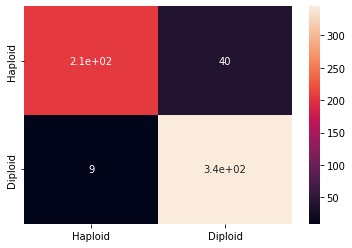

In [ ]:
sns.heatmap(cm, annot=True, xticklabels=['Haploid', 'Diploid'], yticklabels=['Haploid', 'Diploid'])

In [ ]:
def plot_roc_curve(true_y, y_prob): 
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

Model AUC score : 0.9059873225850903


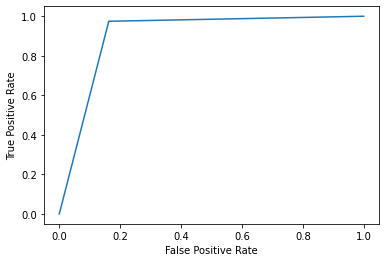

In [ ]:
plot_roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print('Model AUC score : {}'.format(auc))